## Load In Libraries

In [1]:
import math
import ctREFPROP.ctREFPROP as ct
import os
import numpy as np
import matplotlib.pyplot as plt

# Hack for my installation
os.environ['RPPREFIX'] = r'C:\\Program Files (x86)\REFPROP'

root = os.environ['RPPREFIX']
#r = ct.REFPROPFunctionLibrary(os.path.join(root, 'refprop.dll'))
r = ct.REFPROPFunctionLibrary(os.path.join(root, 'REFPRP64.dll'))
r.SETPATHdll(root)

## Real Gas Data Generation

In [10]:



fuel_type='ethane.FLD'

## Conditions
dP = 100
Psweep = np.arange(100,8000+dP,dP)
dT = 0.5
Tsweep = np.arange(80,500+dT,dT)
#Tsweep = np.arange(80,150+dT,dT)

Rho = np.zeros(Psweep.size*Tsweep.size)
Pall = np.zeros(Psweep.size*Tsweep.size)
Tall = np.zeros(Psweep.size*Tsweep.size)
T_sat_V = np.zeros(Psweep.size)
T_sat_L = np.zeros(Psweep.size)


Ru = 8.314

chamberAmb = 'nitrogen.FLD'
amb_type='nitrogen.FLD'
mix_list=fuel_type+"|"+amb_type
ierr, herr = r.SETUPdll(2,mix_list,'HMX.BNC','DEF')
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)
zf=[1,0]
zamb=[0,1]
z = zamb
kk = -1
jj=-1
for P in Psweep:
   
    jj+=1
    for T in Tsweep:
        kk+=1

        ## Inlet Conditions
        
       
        Props = r.TPFLSHdll(T,P,z)
        MW = r.WMOLdll(zf)
        
        

        if Props.ierr==0:
            Rho[kk] = Props.D*MW
            Tall[kk] = T
            Pall[kk] = P
        else:
            Rho[kk] = None
            

    print('%d / %d'%(jj, Psweep.size-1),end='\r')

In [11]:
dP = 10
Psweep2 = np.arange(100,9000+dP,dP)
T_sat_V = np.zeros(Psweep2.size)
T_sat_L = np.zeros(Psweep2.size)
jj=-1
for P in Psweep2:
    jj+=1
    satprops = r.SATPdll(P,z,2)
    if satprops.ierr ==0:
        T_sat_V[jj] = satprops.T
        if T_sat_V[jj]<80:
            T_sat_V[jj] = None
    else:
        T_sat_V[jj] = None
    satprops = r.SATPdll(P,z,1)
    if satprops.ierr ==0:
        T_sat_L[jj] = satprops.T
        if T_sat_L[jj]<80:
            T_sat_L[jj] = None
    else:
        T_sat_L[jj] = None
    print('%d / %d'%(jj, Psweep2.size-1),end='\r')

## Cricondentherm points

In [14]:

iUnits = 0 # in kPa
iMass = 0
iFlag = 1
T = 0
D = 0


ierr, herr = r.SATSPLNdll(z)   
ALL = r.ALLPROPSdll('TMAXT',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondentherm_T = Cri

ALL = r.ALLPROPSdll('PMAXT',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondentherm_P = Cri

ALL = r.ALLPROPSdll('PMAXP',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondenbar_P = Cri

ALL = r.ALLPROPSdll('TMAXP',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondenbar_T = Cri


CriticalProp = r.CRTPNTdll(z,0,0)
if CriticalProp.ierr == 0:
    CP_T = CriticalProp.Tc
    CP_P = CriticalProp.Pc
    

## Contour Plot of Density Nitrogen

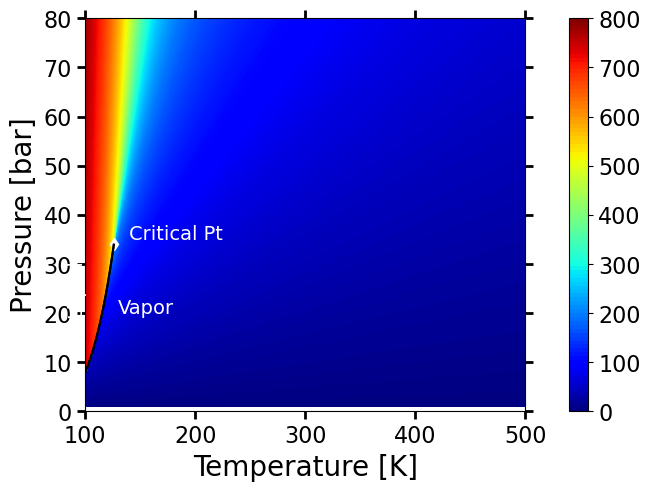

In [15]:
import scipy.ndimage

X, Y = np.meshgrid(Tsweep, Psweep/100)
Rhogrid = np.reshape(Rho, (Psweep.size,Tsweep.size))
RhoSmooth = scipy.ndimage.zoom(Rhogrid, 2)
XSmooth = scipy.ndimage.zoom(X, 2)
YSmooth = scipy.ndimage.zoom(Y, 2)
fig, ax = plt.subplots(constrained_layout=True)

#C = plt.contourf(X,Y, Rhogrid, 1000, cmap='jet')
vmin = 0
vmax=800
#contourf_ = ax.contourf(X,Y,Rhogrid, 1000, cmap='jet', vmin=vmin, vmax=vmax)
#cbar = fig.colorbar(contourf_)

from matplotlib.cm import ScalarMappable
levels = 100

level_boundaries = np.linspace(vmin, vmax, levels + 1)

quadcontourset = ax.contourf(
    X, Y, Rhogrid, 1000, cmap='jet',  # change this to `levels` to get the result that you want
    vmin=vmin, vmax=vmax
)


fig.colorbar(
    ScalarMappable(norm=quadcontourset.norm, cmap=quadcontourset.cmap),
    ticks=range(vmin, vmax+5, 100),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
)





#plt.colorbar();
#cbar.ax.set_ylabel('Density [kg/m$^3$]', fontweight="normal");
#cbar.set_ticks(np.linspace(0, 800, 9))
#cbar.set_ticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800])

#cbar = fig.colorbar(C)
plt.ylim([0, 80])
#plt.ylim([43, 46])#max(Psweep)/100])
plt.xlim([100, 500])
#plt.xlim([145, 150])
plt.ylabel('Pressure [bar]')
plt.xlabel('Temperature [K]')
ax.set_xticks(np.linspace(100, 500, 5))
ax.set_xticklabels(['100', '200', '300', '400', '500'])
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title





font = {'family' : 'normal',
        'weight' : 'normal'}
ax.tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5,right='bool',top='bool')
plt.rc('font', **font)
plt.plot(CP_T,CP_P/100,'wd','LineWidth',10)
plt.plot(T_sat_L,Psweep2/100,'k','LineWidth',5)
plt.plot(T_sat_V,Psweep2/100,'k','LineWidth',5)
plt.text(130,20,'Vapor',fontsize=14, color='w')
plt.text(83,20,'Liquid',fontsize=14, color='w',rotation=90)
plt.text(140,35,'Critical Pt',fontsize=14, color='w')
plt.show()







## Ethane Contour

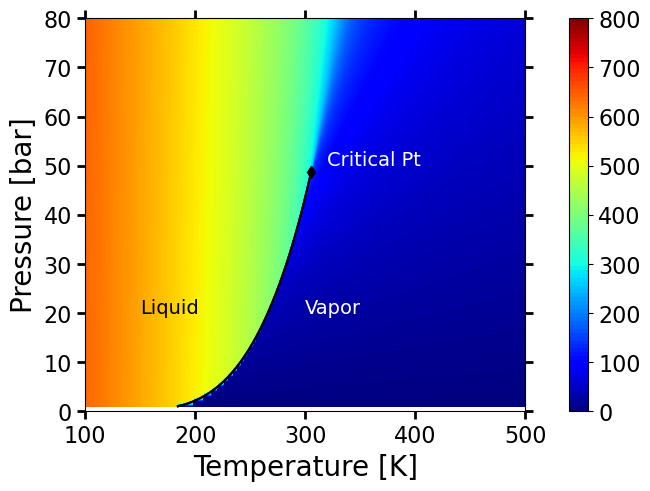

In [8]:
import scipy.ndimage

X, Y = np.meshgrid(Tsweep, Psweep/100)
Rhogrid = np.reshape(Rho, (Psweep.size,Tsweep.size))
RhoSmooth = scipy.ndimage.zoom(Rhogrid, 2)
XSmooth = scipy.ndimage.zoom(X, 2)
YSmooth = scipy.ndimage.zoom(Y, 2)
fig, ax = plt.subplots(constrained_layout=True)

#C = plt.contourf(X,Y, Rhogrid, 1000, cmap='jet')
vmin = 0
vmax=800
#contourf_ = ax.contourf(X,Y,Rhogrid, 1000, cmap='jet', vmin=vmin, vmax=vmax)
#cbar = fig.colorbar(contourf_)

from matplotlib.cm import ScalarMappable
levels = 100

level_boundaries = np.linspace(vmin, vmax, levels + 1)

quadcontourset = ax.contourf(
    X, Y, Rhogrid, 1000, cmap='jet',  # change this to `levels` to get the result that you want
    vmin=vmin, vmax=vmax
)


fig.colorbar(
    ScalarMappable(norm=quadcontourset.norm, cmap=quadcontourset.cmap),
    ticks=range(vmin, vmax+5, 100),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
)





#plt.colorbar();
#cbar.ax.set_ylabel('Density [kg/m$^3$]', fontweight="normal");
#cbar.set_ticks(np.linspace(0, 800, 9))
#cbar.set_ticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800])

#cbar = fig.colorbar(C)
plt.ylim([0, 80])
#plt.ylim([43, 46])#max(Psweep)/100])
plt.xlim([100, 500])
#plt.xlim([145, 150])
plt.ylabel('Pressure [bar]')
plt.xlabel('Temperature [K]')
ax.set_xticks(np.linspace(100, 500, 5))
ax.set_xticklabels(['100', '200', '300', '400', '500'])
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title





font = {'family' : 'normal',
        'weight' : 'normal'}
ax.tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5,right='bool',top='bool')
plt.rc('font', **font)
plt.plot(CP_T,CP_P/100,'kd','LineWidth',10)
plt.plot(T_sat_L,Psweep2/100,'k','LineWidth',5)
plt.plot(T_sat_V,Psweep2/100,'k','LineWidth',5)
plt.text(150,20,'Liquid',fontsize=14, color='k')
plt.text(300,20,'Vapor',fontsize=14, color='w')
plt.text(320,50,'Critical Pt',fontsize=14, color='w')
plt.show()



